In [1]:
import sys
import numpy as np
from pspy import pspy_utils, so_cov, so_dict, so_map, so_mcm
import matplotlib.pyplot as plt
%config InlineBackend.figure_format='retina'

This notebook provides a pspy-only tutorial for using the anisotropic covmat code. All data products can be found in `/tigress/zequnl/PSpipe/project/data_analysis/zach_tutorial`.

The first step is to name the four fields, and provide the polarizations in a list with the different fields a, b, c, and d.

In [14]:
# format is f"{dr6}&{arr}&{split}&{pol}" where i.e. arr='pa6_f150', split='1', pol='T'
lmax = 5400
names = ['dr6&pa6_f150&1&T', 'dr6&pa6_f150&4&T', 'dr6&pa6_f150&1&T','dr6&pa6_f150&4&T']
ids = ['Ta', 'Tb', 'Tc', 'Td']
id2name = dict(zip(ids, names))
splits = [n.split('&')[2] for n in names]
print(splits)

['1', '4', '1', '4']


Next, we provide some windows and ivar files to load in.

In [ ]:
ivardir = "/scratch/gpfs/ACT/dr6v3/maps/dr6v3_20211031/release_bestpass/"
ivar_names = [
    f'{ivardir}/cmb_night_pa6_f150_8way_set{splits[0]}_ivar.fits',
    f'{ivardir}/cmb_night_pa6_f150_8way_set{splits[1]}_ivar.fits',
    f'{ivardir}/cmb_night_pa6_f150_8way_set{splits[2]}_ivar.fits',
    f'{ivardir}/cmb_night_pa6_f150_8way_set{splits[3]}_ivar.fits']
windir = "v3/windows/"
win_names = [
    f'{windir}/window_dr6_pa6_f150.fits',
    f'{windir}/window_dr6_pa6_f150.fits',
    f'{windir}/window_dr6_pa6_f150.fits',
    f'{windir}/window_dr6_pa6_f150.fits']

We provide the $C_\ell$ and $N_\ell$ curves just from npy files, but normally you'd read these from disk through PSpipe.

In [3]:
cls = {
    'TaTc': np.load("v3/ref/cl_dr6&pa6_f150&T.npy")[2:lmax],
    'TaTd': np.load("v3/ref/cl_dr6&pa6_f150&T.npy")[2:lmax],
    'TbTc': np.load("v3/ref/cl_dr6&pa6_f150&T.npy")[2:lmax],
    'TbTd': np.load("v3/ref/cl_dr6&pa6_f150&T.npy")[2:lmax]
}

In [4]:
nls = {
    'Ta': np.load(f"v3/ref/nl_{id2name['Ta']}.npy")[2:lmax],
    'Tb': np.load(f"v3/ref/nl_{id2name['Tb']}.npy")[2:lmax],
    'Tc': np.load(f"v3/ref/nl_{id2name['Tc']}.npy")[2:lmax],
    'Td': np.load(f"v3/ref/nl_{id2name['Td']}.npy")[2:lmax],
}

Let's check that we're getting sensible $C_\ell$ by plotting.

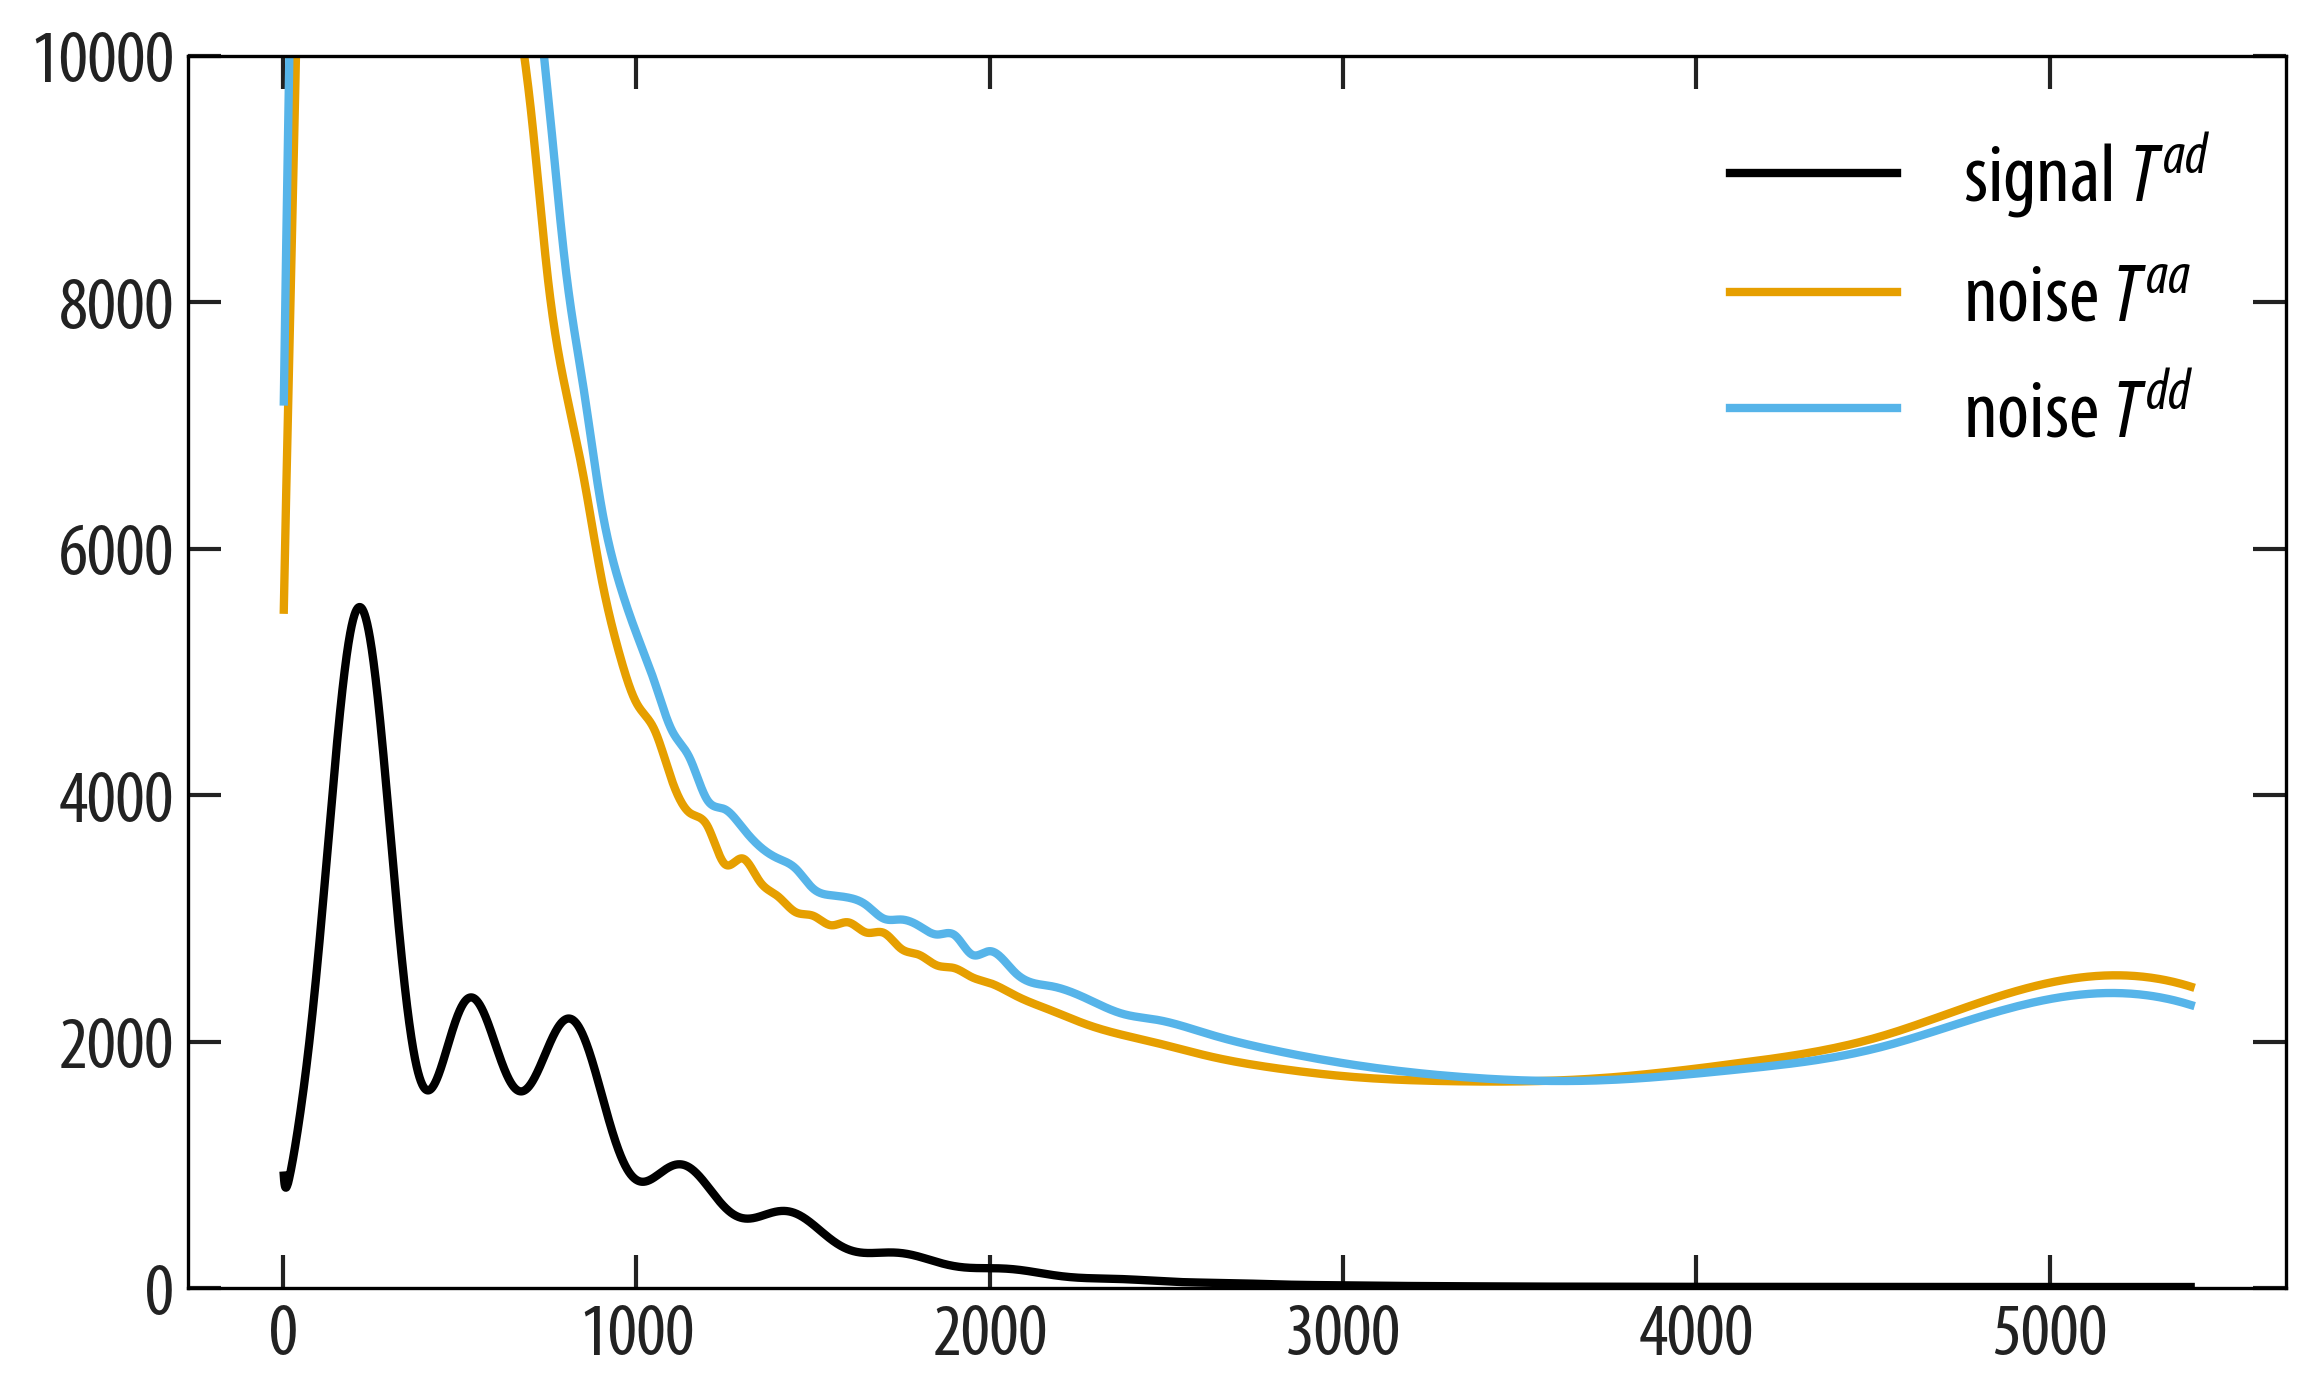

In [5]:
ells = np.arange(2,lmax)
dlfac = ells * (ells + 1) / (2 * np.pi)
plt.plot(ells, cls['TaTd'] * dlfac, '-', label=r"signal $T^{ad}$")
plt.plot(ells, nls['Ta'] * dlfac, '-', label=r"noise $T^{aa}$")
plt.plot(ells, nls['Td'] * dlfac, '-', label=r"noise $T^{dd}$")
plt.ylim(0, 1e4)
plt.legend()

The first nontrivial step is to loop over the four fields, read in the windows and masks, and compute the masked ivar map. 

In [6]:
win = {}
var = {}
white_noise = {}
rls = {}

for id1, ivar_fname, win_fname in zip(ids, ivar_names, win_names):
    ivar1 = so_map.read_map(ivar_fname).data
    var1 = np.reciprocal(ivar1,where=(ivar1!=0))
    win[id1] = so_map.read_map(win_fname)
    white_noise[id1] = so_cov.measure_white_noise_level(var1, win[id1].data)
    var[id1] = so_cov.make_weighted_variance_map(var1, win[id1])
    rls[id1] = np.sqrt(nls[id1] / white_noise[id1])
    print(ivar_fname, white_noise[id1])

/scratch/gpfs/ACT/dr6v3/maps/dr6v3_20211031/release_bestpass//cmb_night_pa6_f150_8way_set1_ivar.fits 0.0005340369392877401
/scratch/gpfs/ACT/dr6v3/maps/dr6v3_20211031/release_bestpass//cmb_night_pa6_f150_8way_set4_ivar.fits 0.0004956277842605803
/scratch/gpfs/ACT/dr6v3/maps/dr6v3_20211031/release_bestpass//cmb_night_pa6_f150_8way_set1_ivar.fits 0.0005340369392877401
/scratch/gpfs/ACT/dr6v3/maps/dr6v3_20211031/release_bestpass//cmb_night_pa6_f150_8way_set4_ivar.fits 0.0004956277842605803


With these, we can compute the couplings.

In [7]:
couplings = so_cov.generate_aniso_couplings_TTTT(ids, splits, win, var, lmax)

Now that we have the coupling functions $\Xi$, we apply the $C_\ell^{\rm th}$ and $R_{\ell}$ to compute the *unbinned pseudo-covariance matrix*.

In [8]:
cov_tttt = so_cov.coupled_cov_aniso_same_pol(ids, cls, rls, couplings)

To make a comparison with the mnms sims we did for v3, 

1. we must apply the mode-coupling matrices (which has the beam in it)
2. undo the transfer function from the k-space filter
3. bin the spectrum

Between steps 2 and 3 we also apply the $D_\ell$ weight, $\ell (\ell+1) / 2\pi$ to match previous work.

In [10]:
binning_file = "/tigress/zequnl/cmb/data/dr6/binning/BIN_ACTPOL_50_4_SC_large_bin_at_low_ell"
sp = "spin0xspin0"
mbb_inv_ab, Bbl_ab = so_mcm.read_coupling("v3/ref/dr6_pa6_f150xdr6_pa6_f150", spin_pairs=[sp])
mbb_inv_cd, Bbl_cd = so_mcm.read_coupling("v3/ref/dr6_pa6_f150xdr6_pa6_f150", spin_pairs=[sp])
full_analytic_cov = mbb_inv_ab[sp] @ cov_tttt @ mbb_inv_cd[sp].T

# ONLY FOR COMPARISON TO PREVIOUS WORK: CONVERT TO COV(D_ell)
full_analytic_cov *= np.outer(dlfac, dlfac)

analytic_cov = so_cov.bin_mat(full_analytic_cov, binning_file, lmax)
tf_bb = np.load("v3/ref/tf_bb.npy")
analytic_cov /= tf_bb

Now we can finally plot the stuff we did in the past, dividing our newly computed covariance matrix by the analytic one.

Text(0, 0.5, '$C_{\\ell\\ell}^{TT,\\mathrm{est}} / C_{\\ell\\ell}^{TT,\\mathrm{analytic,iso,mean\\,noise}}$')

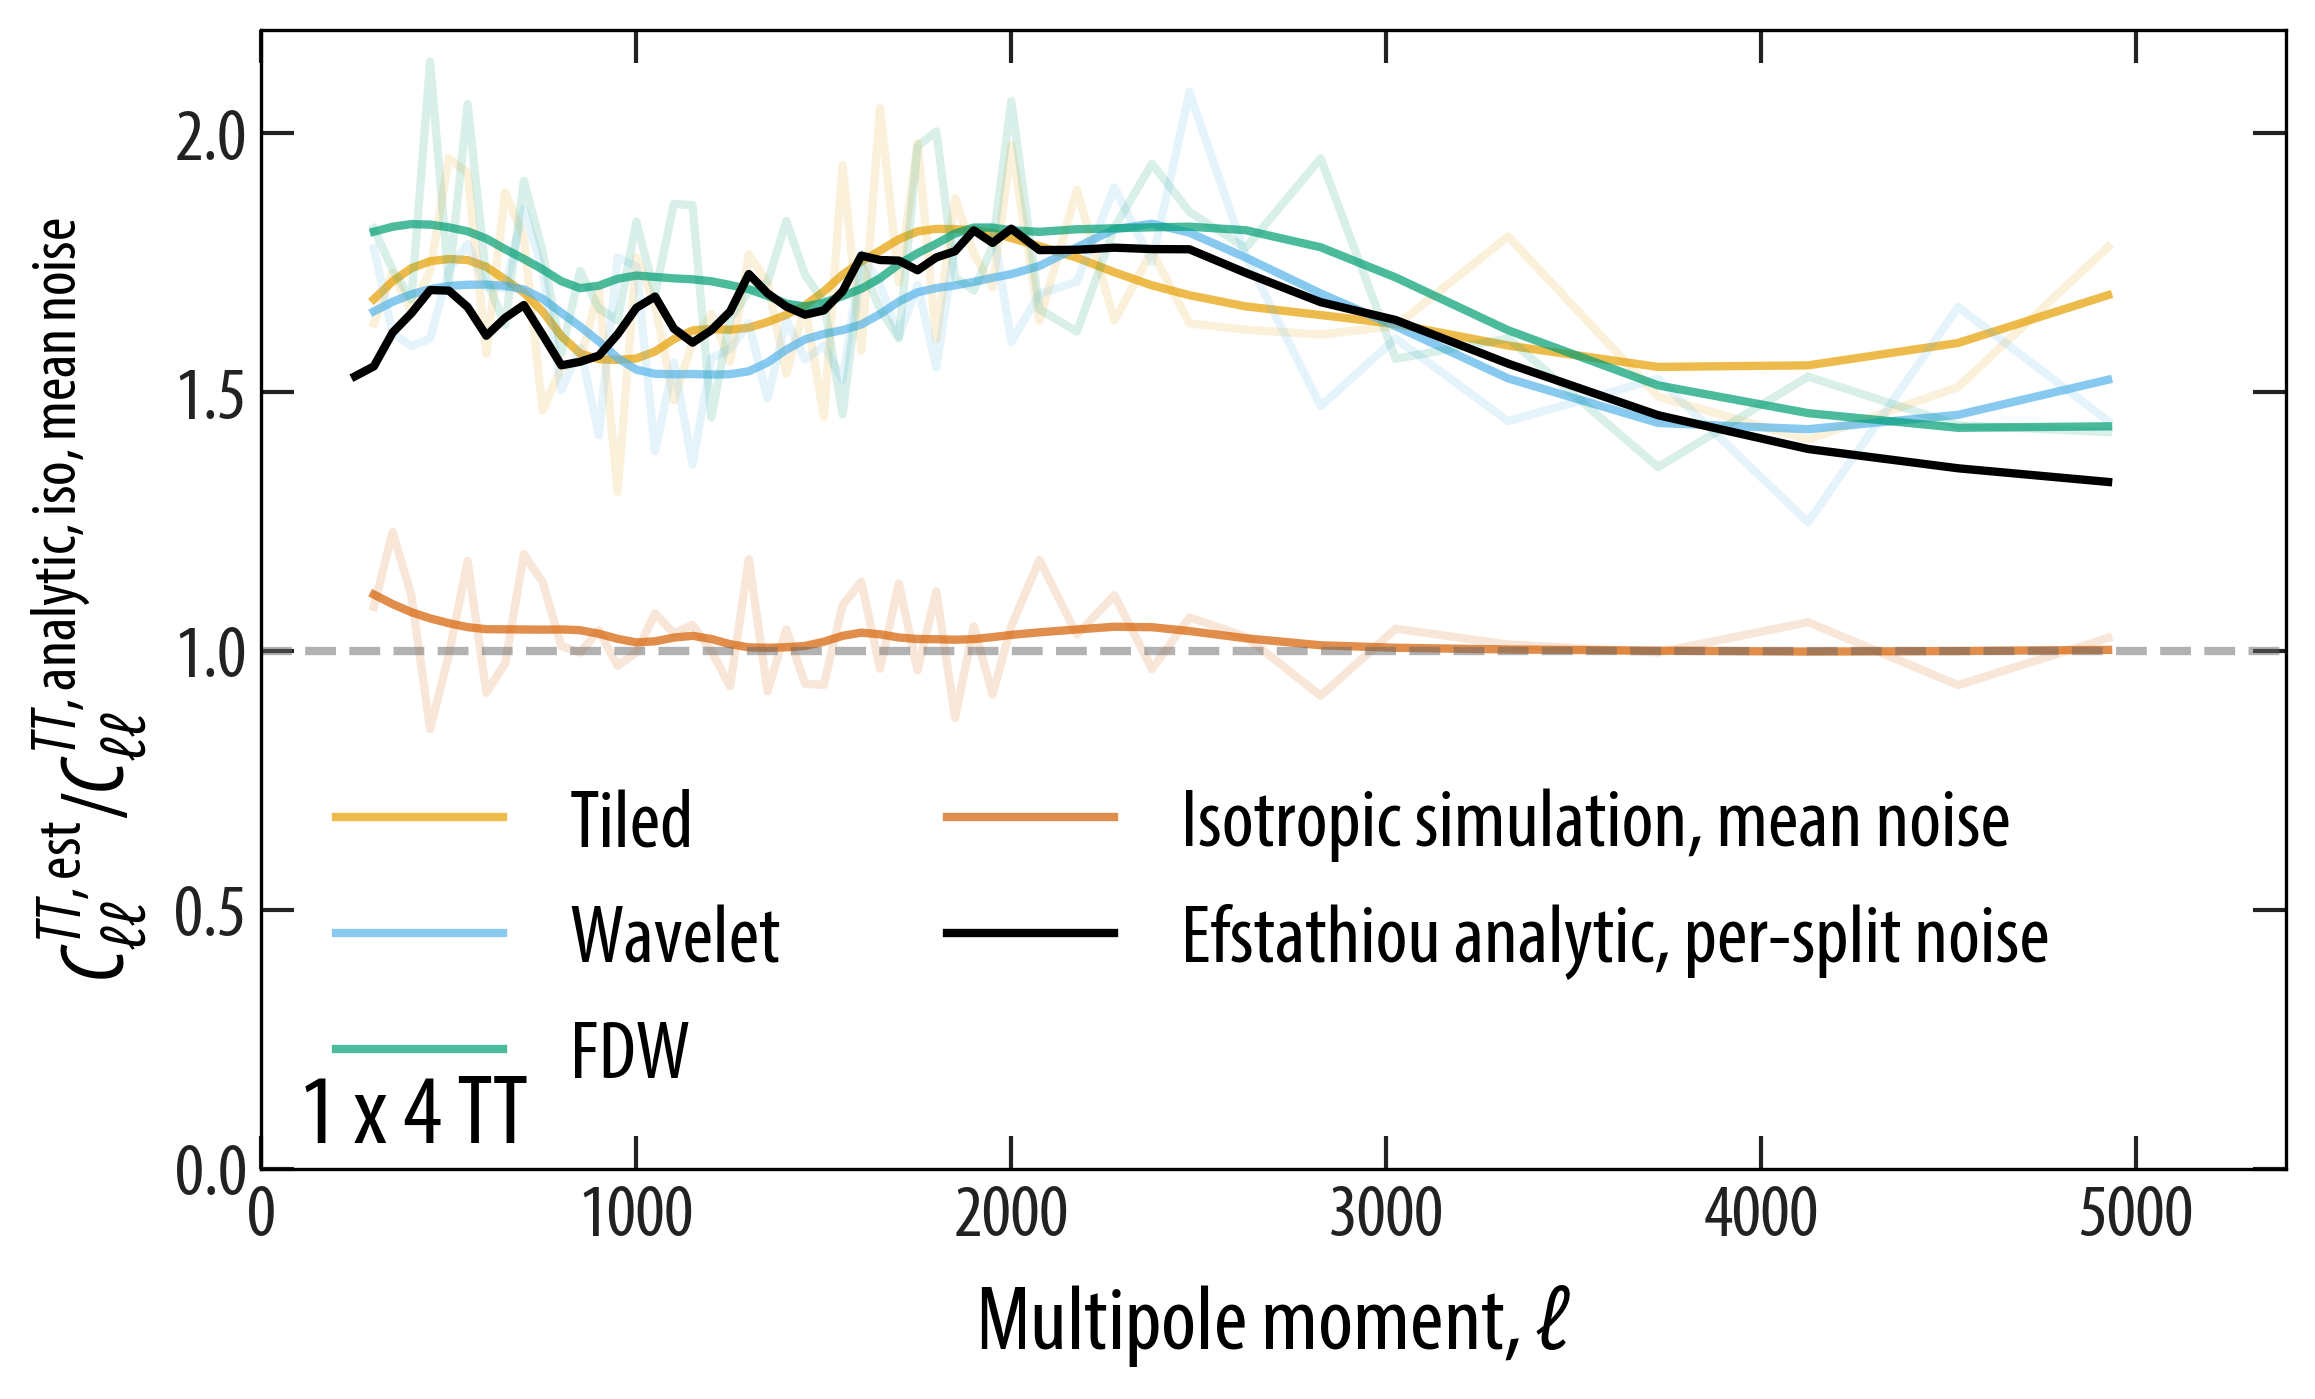

In [15]:
ref_mnms = np.load("v3/ref/mnms_14.npy")
var_hom_g = np.load("v3/ref/old_hom_gauss_cov.npy")
ell = np.load("v3/ref/mnms_ells.npy")
x, y_t, vs_t, y_w, vs_w, y_f, vs_f, y_g, vs_g = ref_mnms.T  # sorry for the poor names

plt.figure()
plt.plot(x, y_t,  alpha=0.15, ls="-", color="C1")
plt.plot(x, vs_t, alpha=0.7, label="Tiled", ls="-", color="C1")
plt.plot(x, y_w,  alpha=0.15, ls="-", color="C2")
plt.plot(x, vs_w, alpha=0.7, label="Wavelet", ls="-", color="C2")
plt.plot(x, y_f,  alpha=0.15, ls="-", color="C3")
plt.plot(x, vs_f, alpha=0.7, label="FDW", ls="-", color="C3")
plt.plot(x, y_g,  alpha=0.15, ls="-", color="C6")
plt.plot(x, vs_g, alpha=0.7, label="Isotropic simulation, mean noise", ls="-", color="C6", lw=2)
start_i = 3
plt.plot(ell[start_i:] , (np.diag(analytic_cov) / var_hom_g)[start_i:] , 
    "k-", label="Efstathiou analytic, per-split noise")
plt.ylim(0., 2.2)
plt.text(100, 0.05, "1 x 4 TT", fontsize=24)
plt.xlim(0,lmax)
plt.legend(ncol=2)
plt.axhline(1.0, alpha=0.5, ls="--")

plt.xlabel(r"Multipole moment, $\ell$", labelpad=8)
plt.ylabel(r"$C_{\ell\ell}^{" + "TT" +
    r",\mathrm{est}} / C_{\ell\ell}^{" + "TT" + r",\mathrm{analytic,iso,mean\,noise}}$", labelpad=6)